In [16]:
from langchain_core.tools import tool
from typing import Annotated
from langchain_experimental.utilities import PythonREPL
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_openai import OpenAI
from typing import TypedDict, Annotated, List, Union
from langchain_core.agents import AgentAction, AgentFinish
from langchain_core.messages import BaseMessage
import operator
from langchain_core.agents import AgentFinish
from langgraph.prebuilt.tool_executor import ToolExecutor
from langchain.agents import create_json_chat_agent
from langchain_core.prompts import (
     ChatPromptTemplate,
     SystemMessagePromptTemplate,
     PromptTemplate, 
     MessagesPlaceholder, 
     HumanMessagePromptTemplate )
import json
import os
from typing import List, Union # typing: 코드에서 사용되는 데이터 유형을 정의하는 데 도움이 되는 Python의 내장 라이브러리
from langgraph.graph import END, StateGraph
from langchain_core.messages import (
    AIMessage,
    HumanMessage,
    ChatMessage,
    SystemMessage,
    FunctionMessage,
    ToolMessage,
)
from tavily import TavilyClient
from langchain_anthropic import ChatAnthropic

In [8]:
TAVILY_API_KEY = ""
Openai_API_KEY = ""
GROQ_API_KEY = ""
coher_API_KEY = ""
claude_api_key=""

In [26]:
class AgentState(TypedDict):
   input: str
   chat_history: list[BaseMessage]
   agent_outcome: Union[AgentAction, AgentFinish, None]
   intermediate_steps: Annotated[list[tuple[AgentAction, str]], operator.add]

# search = TavilyClient(api_key=TAVILY_API_KEY)
os.environ["TAVILY_API_KEY"] = TAVILY_API_KEY
search = TavilySearchResults(max_results=1)
repl = PythonREPL()

chat_model = ChatAnthropic(model="claude-3-5-sonnet-20240620",api_key=claude_api_key)

In [27]:
def extract_json(text):
    try:
        # Find the index where the JSON part starts (after "AI:")
        start_index = text.find("AI:")
        if start_index != -1:
            # Extract the JSON part of the text
            json_str = text[start_index + len("AI:"):].strip()
            # Parse the JSON object
            json_obj = json.loads(json_str)
            return json_obj
        else:
            # If "AI:" prefix not found, return None
            return None
    except json.JSONDecodeError as e:
        # Handle JSON decoding errors
        print(f"Error decoding JSON: {e}")
        return None
    except Exception as e:
        # Handle other unexpected errors
        print(f"Unexpected error: {e}")
        return None

In [28]:
@tool
# 정상 파이썬 작동 코드인지 확인 
def python_repl(
    code: Annotated[str, "The python code to execute to generate your chart."]
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    return f"Succesfully executed:\n```python\n{code}\n```\nStdout: {result}"

tools = [search, python_repl]

In [29]:
prompt2 = ChatPromptTemplate(
    input_variables=["agent_scratchpad", "input", "tool_names", "tools"],
    input_types={
        "chat_history": List[
            Union[
                AIMessage,
                HumanMessage,
                ChatMessage,
                SystemMessage,
                FunctionMessage,
                ToolMessage,
            ]
        ],
        "agent_scratchpad": List[
            Union[
                AIMessage,
                HumanMessage,
                ChatMessage,
                SystemMessage,
                FunctionMessage,
                ToolMessage,
            ]
        ],
    },
    messages=[
        SystemMessagePromptTemplate(
            prompt=PromptTemplate(
                input_variables=[],
                template="""Assistant is a large language model trained by OpenAI.\n\nAssistant is designed to be able to assist with a wide range 
                         of tasks, from answering simple questions to providing in-depth explanations and discussions on a wide range of topics. 
                         As a language model, Assistant is able to generate human-like text based on the input it receives, allowing it to engage 
                         in natural-sounding conversations and provide responses that are coherent and relevant to the topic at hand.
                         \n\nAssistant is constantly learning and improving, and its capabilities are constantly evolving. It is able to process 
                         and understand large amounts of text, and can use this knowledge to provide accurate and informative responses to a wide 
                         range of questions. Additionally, Assistant is able to generate its own text based on the input it receives, allowing it 
                         to engage in discussions and provide explanations and descriptions on a wide range of topics.
                         \n\nOverall, Assistant is a powerful system that can help with a wide range of tasks and provide valuable insights and 
                         information on a wide range of topics. Whether you need help with a specific question or just want to have a conversation
                         about a particular topic, Assistant is here to assist.""",
            )
        ),
        MessagesPlaceholder(variable_name="chat_history", optional=True),
        HumanMessagePromptTemplate(
            prompt=PromptTemplate(
                input_variables=["input", "tool_names", "tools"],
                template="""TOOLS\n------\nAssistant can ask the user to use tools to look up information that may be helpful in answering the users original question. 
The tools the human can use are:\n\n{tools}\n\nRESPONSE FORMAT INSTRUCTIONS\n----------------------------\n\nWhen responding to me, please output a response in one of two formats:\n\n**Option 1:**\nUse this if you want the human to use a tool.\nMarkdown code snippet formatted in the following schema:\n\n```json\n{{\n    "action": string, \\ The action to take. Must be one of {tool_names}\n    "action_input": string \\ The input to the action\n}}\n```\n\n**Option #2:**\nUse this if you can respond directly to the human after tool execution. Markdown code snippet formatted in the following schema:\n\n```json\n{{\n    "action": "Final Answer",\n    "action_input": string \\ You should put what you want to return to use here\n}}\n```\n\nUSER\'S INPUT\n--------------------\nHere is the user\'s input (remember to respond with a markdown code snippet of a json blob with a single action, and NOTHING else):\n\n{input}
""",

            )
        ),
        MessagesPlaceholder(variable_name="agent_scratchpad"),
    ],
)

agent_runnable = create_json_chat_agent(chat_model, tools, prompt2)

tool_executor = ToolExecutor(tools)

/tmp/ipykernel_144/1807120295.py:58: LangGraphDeprecationWarning: ToolExecutor is deprecated as of version 0.2.0 and will be removed in 0.3.0. Use langgraph.prebuilt.ToolNode instead.
  tool_executor = ToolExecutor(tools)


In [30]:
def run_agent(data):
    agent_outcome = agent_runnable.invoke(data)
    return {"agent_outcome": agent_outcome}

def execute_tools(data):
    agent_action = data['agent_outcome']
    tool = agent_action.tool
    tool_input = agent_action.tool_input

    # Human in the Loop: Confirm tool execution with the user
    response = input(f"[y/n] continue with: {tool} with {tool_input}?")
    if response == "n":
        raise ValueError

    output = tool_executor.invoke(agent_action)
    data["intermediate_steps"].append((agent_action, str(output)))
    return data

# Define logic to determine which edge to follow in conditional branching
def should_continue(data):
    if isinstance(data['agent_outcome'], AgentFinish):
        return "end"
    else:
        return "continue"

In [31]:
# Define a new graph
workflow = StateGraph(AgentState)

# Define two nodes for looping
workflow.add_node("agent", run_agent)
workflow.add_node("action", execute_tools)

# Set entry point
workflow.set_entry_point("agent")

# Add conditional edges
workflow.add_conditional_edges(
    "agent",
    should_continue,
    {
        "continue": "action",
        "end": END,
    },
)

workflow.add_edge("action", "agent")

app = workflow.compile()

inputs = {"input": "what is the weather in taiwan", "chat_history": []}
result = app.invoke(inputs)

print(result["agent_outcome"].return_values["output"])

[y/n] continue with: tavily_search_results_json with current weather in Taiwan? ㅛ


Based on the latest weather information I found, the current weather in Taiwan is partly cloudy with a temperature of 34.3°C (93.7°F). The humidity is at 67%, and there's a westerly wind blowing at 16.9 km/h (10.5 mph). It feels even warmer though, with a 'feels like' temperature of 41.4°C (106.5°F) due to the humidity. The UV index is high at 8.0, so sun protection would be advisable if you're going outside. There's no precipitation expected at the moment. This information is current as of August 22, 2024, at 17:00 local time in Taiwan.


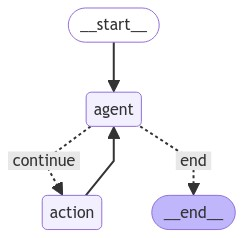

In [33]:
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod

display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)